In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import time

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 11

import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [14]:
import h5py

with h5py.File(r"E:\00_CeSOP\data\Xenium_V1_hLymphNode_nondiseased_section_outs\cell_feature_matrix.h5", 'r') as f:
    # 打印出文件中的所有组和数据集
    def print_structure(name, obj):
        print(name)
    
    f.visititems(print_structure)  # 递归列出所有组和数据集


matrix
matrix/barcodes
matrix/data
matrix/features
matrix/features/_all_tag_keys
matrix/features/feature_type
matrix/features/genome
matrix/features/id
matrix/features/name
matrix/indices
matrix/indptr
matrix/shape


In [20]:
import h5py
import pandas as pd
from scipy.sparse import csr_matrix

file_path = r"E:\00_CeSOP\data\Xenium_V1_hLymphNode_nondiseased_section_outs\cell_feature_matrix.h5"

with h5py.File(file_path, 'r') as f:
    # 读取稀疏矩阵的组件
    data = f['matrix/data'][:]           # 非零值
    indices = f['matrix/indices'][:]     # 行索引---基因
    indptr = f['matrix/indptr'][:]       # 列指针---细胞
    shape = f['matrix/shape'][:]         # 矩阵形状 (genes x cells)
    
    # 如果细胞在列，基因在行（需要转置）
    if len(indptr) == shape[1] + 1:
        matrix = csr_matrix((data, indices, indptr), shape=(shape[1], shape[0]))
    else:
        # 默认布局：细胞在行，基因在列
        matrix = csr_matrix((data, indices, indptr), shape=shape)

    # 读取细胞条形码和基因名
    barcodes = f['matrix/barcodes'][:].astype(str)  # 细胞ID
    genes = f['matrix/features/name'][:].astype(str)  # 基因名
    
    print("The number of cells:", len(barcodes))  # 打印 indptr 的长度
    print("The number of genes:", len(genes))  

# 转换为 Pandas DataFrame
df = pd.DataFrame(matrix.toarray(), index=barcodes, columns=genes)

print(df.head())

The number of cells: 377985
The number of genes: 541
            ABCC11  ACE2  ACKR1  ACTA2  ACTG2  ADAM28  ADAMTS1  ADGRE1  \
aaaabaep-1       0     0      0      0      0       0        0       0   
aaaabhgn-1       0     0      0      0      0       2        0       0   
aaaabjel-1       0     0      0      0      1       3        0       0   
aaaaeadi-1       0     0      0      0      2       0        0       0   
aaaaggdm-1       0     0      0      0      2       1        0       0   

            ADGRL4  ADH1C  ...  BLANK_0490  BLANK_0491  BLANK_0492  \
aaaabaep-1       0      0  ...           0           0           0   
aaaabhgn-1       0      0  ...           0           0           0   
aaaabjel-1       0      0  ...           0           0           0   
aaaaeadi-1       0      0  ...           0           0           0   
aaaaggdm-1       1      0  ...           0           0           0   

            BLANK_0493  BLANK_0494  BLANK_0495  BLANK_0496  BLANK_0497  \
aaaabae

In [22]:
## 淋巴结基因与甲状腺功能减退性状基因
# 读取asthma gwas数据中所有基因
t = 48
trait = pd.read_csv(r"E:\00_CeSOP\data\poly_posterior_prior_gene\%s_new.txt"%(t+1),sep = "\t")
trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\core\%s.txt"%(t+1),sep = "\t",header= None)[0])
trait_core = trait[trait["gene name"].isin(trait_coregene)]

trait_perigene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\periphery\%s.txt"%(t+1),sep = "\t",header= None)[0])
trait_peri = trait[trait["gene name"].isin(trait_perigene)]


In [24]:
'''读取背景网络'''
import numpy as np
import networkx as nx

def openPPI(filename):
    '''
        打开PPI
        文件格式 gene1_name gene1_id gene2_name gene2_id
        返回值：网络[节点是gene name]
    '''
    G = nx.Graph()
    a=open(filename,"r")
    next(a)

    for i in a:
        n=i.strip().split("\t")
        G.add_edge(n[0],n[3])
        G.add_node(n[0])
        G.add_node(n[3])
    a.close()
    return G


# 计算最大连通分支
def Lcc(G,genename):
    '''
        输入图网络和一个列表，计算最大连通分支lcc
        G：图，这里图中的节点是基因name
        genename：用于计算lcc的genename列表
    '''

    g = nx.subgraph(G,genename)
    if len(genename)==0:
        largest = 0
        l = []
        return l,largest
    else:
        try:
            l = max(nx.connected_components(g),key=len)  #如果随机选取的gene没有连通分支的话，会报错，添加判断条件
            largest = len(l)     #最大联通分支
        except ValueError as e:
            l = genename[0]    # 假设genename列表中的第一个基因为最大连通分支
            largest = 1        #设置最大联通分支数为1
        return list(l),largest
    
G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")

In [28]:
trancription_49_coregenes = list(set(trait_coregene) & set(list(df.columns)))
l,lcc = Lcc(G,trancription_49_coregenes)
print(len(trancription_49_coregenes),l,lcc)

13 ['CD2', 'CTLA4', 'CD247', 'CD86', 'CD28'] 5


In [29]:
trancription_49_perigenes = list(set(trait_perigene) & set(list(df.columns)))
l,lcc = Lcc(G,trancription_49_perigenes)
print(len(trancription_49_perigenes),l,lcc)

127 ['SLAMF7', 'MYBPC1', 'CXCR4', 'CDK1', 'CENPF', 'TNC', 'FAS', 'MNDA', 'CD247', 'PLCG2', 'CD28', 'CD3E', 'ESR1', 'MDM2', 'PTPRC', 'MYC', 'MKI67', 'EGFR', 'CD3D', 'CTLA4', 'SMYD2', 'FHL2', 'BCL2L11', 'CD86', 'FCGR3A', 'SLAMF1', 'CD2', 'MYLK', 'MEF2C'] 29


In [30]:
# file_path = r"E:\00_CeSOP\data\Xenium_V1_humanLung_Cancer_FFPE_outs\cell_feature_matrix.h5"
# 
# with h5py.File(file_path, 'r') as f:
#     # 读取稀疏矩阵的组件
#     data = f['matrix/data'][:]           # 非零值
#     indices = f['matrix/indices'][:]     # 行索引---基因
#     indptr = f['matrix/indptr'][:]       # 列指针---细胞
#     shape = f['matrix/shape'][:]         # 矩阵形状 (genes x cells)
#     
#     # 如果细胞在列，基因在行（需要转置）
#     if len(indptr) == shape[1] + 1:
#         matrix = csr_matrix((data, indices, indptr), shape=(shape[1], shape[0]))
#     else:
#         # 默认布局：细胞在行，基因在列
#         matrix = csr_matrix((data, indices, indptr), shape=shape)
# 
#     # 读取细胞条形码和基因名
#     barcodes = f['matrix/barcodes'][:].astype(str)  # 细胞ID
#     genes = f['matrix/features/name'][:].astype(str)  # 基因名
#     
#     print("The number of cells:", len(barcodes))  # 打印 indptr 的长度
#     print("The number of genes:", len(genes))  
# 
# # 转换为 Pandas DataFrame
# df = pd.DataFrame(matrix.toarray(), index=barcodes, columns=genes)
# 
# print(df.head())
# 
# # 读取asthma gwas数据中所有基因
# t = 28
# trait = pd.read_csv(r"E:\00_CeSOP\data\poly_posterior_prior_gene\%s_new.txt"%(t+1),sep = "\t")
# trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\core\%s.txt"%(t+1),sep = "\t",header= None)[0])
# trait_core = trait[trait["gene name"].isin(trait_coregene)]
# 
# trait_perigene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\periphery\%s.txt"%(t+1),sep = "\t",header= None)[0])
# trait_peri = trait[trait["gene name"].isin(trait_perigene)]
# 
# trancription_49_coregenes = list(set(trait_coregene) & set(list(df.columns)))
# G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")
# l,lcc = Lcc(G,trancription_49_coregenes)
# print(len(trancription_49_coregenes),l,lcc)
# 
# trancription_49_perigenes = list(set(trait_perigene) & set(list(df.columns)))
# G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")
# l,lcc = Lcc(G,trancription_49_perigenes)
# print(len(trancription_49_perigenes),l,lcc)

The number of cells: 162254
The number of genes: 541
            ABCC11  ACE2  ACKR1  ACTA2  ACTG2  ADAM28  ADAMTS1  ADGRE1  \
aaaadpbp-1       0     0      0      0      0       0        0       0   
aaaaficg-1       0     0      0      0      1       0        0       0   
aaabbaka-1       0     0      0      0      1       1        0       0   
aaabbjoo-1       0     0      0      0      0       1        0       0   
aaablchg-1       0     0      0      0      0       0        0       0   

            ADGRL4  ADH1C  ...  UnassignedCodeword_0490  \
aaaadpbp-1       0      0  ...                        0   
aaaaficg-1       0      0  ...                        0   
aaabbaka-1       0      0  ...                        0   
aaabbjoo-1       0      0  ...                        0   
aaablchg-1       0      0  ...                        0   

            UnassignedCodeword_0491  UnassignedCodeword_0492  \
aaaadpbp-1                        0                        0   
aaaaficg-1         

In [ ]:
## 肺部空间转录组数据  https://gene.ai.tencent.com/SpatialOmics/data?dataID=2135

In [32]:
filePath = r"E:\00_CeSOP\data\10X_Visium_gracia2021genome_lungorganoid_V19D02-088_B1_data.h5ad"
annData = sc.read_h5ad(filePath)

                        x      y
AAACGGGCGTACGGGT-1  31062  37820
AAACTCGTGATATAAG-1  37449  16657
AAATCCGATACACGCC-1  29904  37819
AAATGATTCGATCAGC-1  36870  15648
AAATGCTCGTTACGTT-1  11672  13111


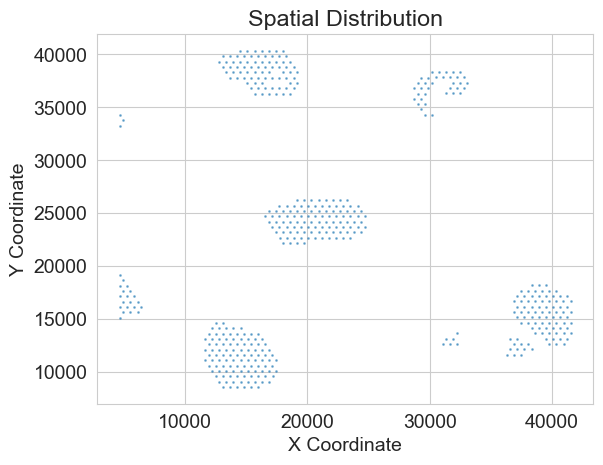

In [67]:
# 提取空间位置信息
spatial_coords = annData.obsm['spatial']
# 转为 DataFrame 并加入 obs
annData.obs[['x', 'y']] = pd.DataFrame(spatial_coords, index=annData.obs.index)
# 绘制空间分布图
plt.scatter(annData.obs['x'], annData.obs['y'], s=1, alpha=0.5)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial Distribution")
# plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
plt.show()

In [46]:
# 转换为 Pandas DataFrame
import pandas as pd
# 稀疏矩阵形式
expression_matrix = annData.X

# 转换为普通的 NumPy 数组
dense_matrix = expression_matrix.toarray() if not isinstance(expression_matrix, np.ndarray) else expression_matrix

lung_df = pd.DataFrame(
    dense_matrix,
    index=annData.obs_names,  # 细胞名称
    columns=annData.var_names  # 基因名称
)
# print(df.head())
print("The number of genes:",len(lung_df.columns))
print("The number of cells:",len(lung_df.index))

                    MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
AAACGGGCGTACGGGT-1          0.0      0.0    0.0         0.0         0.0   
AAACTCGTGATATAAG-1          0.0      0.0    0.0         0.0         0.0   
AAATCCGATACACGCC-1          0.0      0.0    0.0         0.0         0.0   
AAATGATTCGATCAGC-1          1.0      0.0    0.0         0.0         0.0   
AAATGCTCGTTACGTT-1          0.0      0.0    0.0         0.0         0.0   

                    AL627309.2  AL627309.4  AL732372.1  OR4F29  AC114498.1  \
AAACGGGCGTACGGGT-1         0.0         0.0         0.0     0.0         0.0   
AAACTCGTGATATAAG-1         0.0         0.0         0.0     0.0         0.0   
AAATCCGATACACGCC-1         0.0         0.0         0.0     0.0         0.0   
AAATGATTCGATCAGC-1         0.0         0.0         0.0     0.0         0.0   
AAATGCTCGTTACGTT-1         0.0         0.0         0.0     0.0         0.0   

                    ...  AC007325.2  BX072566.1  AL354822.1  AC023491.2  \
AAACG

In [47]:
t = 28
trait = pd.read_csv(r"E:\00_CeSOP\data\poly_posterior_prior_gene\%s_new.txt"%(t+1),sep = "\t")
trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\core\%s.txt"%(t+1),sep = "\t",header= None)[0])
trait_core = trait[trait["gene name"].isin(trait_coregene)]

trait_perigene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\periphery\%s.txt"%(t+1),sep = "\t",header= None)[0])
trait_peri = trait[trait["gene name"].isin(trait_perigene)]

trancription_49_coregenes = list(set(trait_coregene) & set(list(lung_df.columns)))
G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")
l,lcc = Lcc(G,trancription_49_coregenes)
print(len(trancription_49_coregenes),lcc)

trancription_49_perigenes = list(set(trait_perigene) & set(list(lung_df.columns)))
G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")
l,lcc = Lcc(G,trancription_49_perigenes)
print(len(trancription_49_perigenes),lcc)

133 41
3117 2818


In [39]:
'''统计每个细胞非零表达的基因数目'''
# 如果是稀疏矩阵
if not isinstance(expression_matrix, np.ndarray):
    non_zero_counts = (expression_matrix != 0).sum(axis=1)  # 每行（细胞）不为0的数量
else:
    # 如果是普通稠密矩阵
    non_zero_counts = (expression_matrix != 0).sum(axis=1)

annData.obs["non_zero_genes"] = non_zero_counts
print(annData.obs[["non_zero_genes"]].head())

                    non_zero_genes
AAACGGGCGTACGGGT-1            2236
AAACTCGTGATATAAG-1            2587
AAATCCGATACACGCC-1            1952
AAATGATTCGATCAGC-1            2931
AAATGCTCGTTACGTT-1            1918


In [49]:
## 计算一组基因集合的表达值均值
def expressValue(genelist,annData_df,cell):
    '''
    :param genelist: 要计算的gene列表
    :param annData_df: 单细胞表达数据的df
    :param cell:  第几个细胞
    :return:
    '''

    # cell_expressedvalue = annData_df.loc[annData_df.index[cell],genelist]
    cell_expressedvalue = annData_df.loc[cell,genelist]
    if len(cell_expressedvalue)==0:
        return 0,0
    else:
        return sum(cell_expressedvalue), sum(cell_expressedvalue)/len(cell_expressedvalue)

In [50]:
# 计算最大连通分支，并返回最大连通分支上的基因表达值之和、均值
def lccExpressedValue(G,genename,annData_df,cell):
    '''
    :param g: 选定的背景网络
    :param genename:
    :param annData_df:
    :param cell:
    :return:
    '''

    lccgenelist, largest = Lcc(G,genename)
    lcc_expresssum,lcc_expressmean = expressValue(lccgenelist,annData_df,cell)
    return lcc_expresssum,lcc_expressmean

In [51]:
import random
def LccExpress_mean(g,genelist,ran,annData_df,cell):
    '''
    每次从网络G的所有基因中随机选择genelist数量的gene，计算均值和标准差
    g:背景网络
    genelist：
    ran：随机次数
    返回：表达值之和、表达值均值的多次随机的均值和标准差
    '''

    all_genes = g.nodes()  # 背景网络中的gene

    #做随机实验
    l_list = []         #lcc列表
    l1_list = []         #lcc列表
    l2_list = []         #lcc列表
    for j in range(ran):
        black_nodes = random.sample(all_genes,len(genelist))
        l,largest_ran = Lcc(g,black_nodes)
        lcc_expresssum,lcc_expressmean = lccExpressedValue(g,black_nodes,annData_df,cell)

        l_list.append(largest_ran)
        l1_list.append(lcc_expresssum)
        l2_list.append(lcc_expressmean)

    #计算lcczscore
    lcc_mean = np.mean(l_list)
    lcc_std  = np.std(l_list)

    lcc1_mean = np.mean(l1_list)
    lcc1_std  = np.std(l1_list)

    lcc2_mean = np.mean(l2_list)
    lcc2_std  = np.std(l2_list)

    return lcc_mean,lcc_std,lcc1_mean,lcc1_std,lcc2_mean,lcc2_std

In [52]:
# 计算lcczscore
def lccZscore(Lcc,lcc_mean,lcc_std):
    if lcc_std == 0:
        zscore = 0
    else:
        zscore = (Lcc - lcc_mean)/lcc_std
        zscore = round(zscore,6)
    return zscore


In [53]:
# 计算某一组基因集合的lccexpresszscore
# G：整个背景网络
# g：随机选择基因集合的背景
def gensetLccExpressZscore(G,g,genelist,ran,annData_df,cell):
    l,lcc = Lcc(G,genelist)
    lcc_expresssum,lcc_expressmean = lccExpressedValue(G,genelist,annData_df,cell)
    lcc_mean,lcc_std,lcc_expresssum_mean,lcc_expresssum_std,lcc_expressmean_mean,lcc_expressmean_std = \
        LccExpress_mean(g,genelist,ran,annData_df,cell)

    lcc_zscore = lccZscore(lcc,lcc_mean,lcc_std)
    lcc_expresssum_zscore = lccZscore(lcc_expresssum,lcc_expresssum_mean,lcc_expresssum_std)
    lcc_expressmean_zscore = lccZscore(lcc_expressmean,lcc_expressmean_mean,lcc_expressmean_mean)

    return lcc_zscore,lcc_expresssum_zscore,lcc_expressmean_zscore

In [64]:
t = 28
# 读取asthma gwas数据中所有基因
trait = pd.read_csv(r"E:\00_CeSOP\data\poly_posterior_prior_gene\%s_new.txt"%(t+1),sep = "\t")
trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\core\%s.txt"%(t+1),sep = "\t",header= None)[0])
trait_perigene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\periphery\%s.txt"%(t+1),sep = "\t",header= None)[0])

filePath = r"E:\00_CeSOP\data\10X_Visium_gracia2021genome_lungorganoid_V19D02-088_B1_data.h5ad"
annData = sc.read_h5ad(filePath)

## 分别计算核心和外围
for gene in ["core","peri"][1:2]:
    
    # 细胞有表达的asthma核心、外围基因
    if gene == "core":
        genelist = trait_coregene
    elif gene == "peri":
        genelist = trait_perigene

    expressedGenes = lung_df.apply(lambda row: lung_df.columns[row.to_numpy().nonzero()[0]].tolist(), axis=1)
    celllist = list(lung_df.index)

    # 计算每个细胞中的结果
    count = 0
    result_list = []
    for cell in celllist:   #cell是细胞名字
        count+=1
        
        # 单细胞有表达的网络基因
        singlecell_network_genelist = list(set(expressedGenes[cell]) & set(list(G.nodes())))        
        # 构建单细胞子网络
        g = nx.subgraph(G,singlecell_network_genelist)
        core_scnet_genelist = list(set(genelist) & set(singlecell_network_genelist))
        l,lcc = Lcc(G,core_scnet_genelist)
        if (count % 10) == 0:
            print(gene,str(count)+"/"+str(len(celllist)),len(singlecell_network_genelist),len(core_scnet_genelist),lcc,str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
       
        # lcc_expresszscore
        lcczscore,lcc_expresssum_zscore,lcc_expressmean_zscore = \
            gensetLccExpressZscore(G,g,core_scnet_genelist,20,lung_df,cell)  # 随机50次
        result_list.append([cell,len(core_scnet_genelist),lcc,lcczscore,lcc_expresssum_zscore,lcc_expressmean_zscore])

    df_singcell = pd.DataFrame(result_list)
    df_singcell.columns = ["cell","genenum","lcc","lcczscore","lcc_expresssum_zscore","lcc_expressmean_zscore"]
    df_singcell.to_csv(r"E:\00_CeSOP\results\spatial-domain\%s_asthma_lung_spatial.csv"%(gene))


peri 10/444 1468 300 160 2024-11-24 20:22:05
peri 20/444 1866 327 152 2024-11-24 20:22:15
peri 30/444 1949 360 184 2024-11-24 20:22:21
peri 40/444 1868 364 219 2024-11-24 20:22:27
peri 50/444 855 154 65 2024-11-24 20:22:33
peri 60/444 1988 356 196 2024-11-24 20:22:41
peri 70/444 1560 292 131 2024-11-24 20:22:48
peri 80/444 885 142 40 2024-11-24 20:22:55
peri 90/444 1603 289 125 2024-11-24 20:23:03
peri 100/444 1699 301 158 2024-11-24 20:23:09
peri 110/444 1786 356 203 2024-11-24 20:23:16
peri 120/444 1809 336 196 2024-11-24 20:23:23
peri 130/444 829 146 50 2024-11-24 20:23:30
peri 140/444 1982 368 204 2024-11-24 20:23:36
peri 150/444 1736 343 187 2024-11-24 20:23:41
peri 160/444 1031 172 76 2024-11-24 20:23:48
peri 170/444 1435 257 127 2024-11-24 20:23:53
peri 180/444 848 149 21 2024-11-24 20:23:59
peri 190/444 1329 264 125 2024-11-24 20:24:04
peri 200/444 2518 464 305 2024-11-24 20:24:09
peri 210/444 1663 312 145 2024-11-24 20:24:15
peri 220/444 1550 294 150 2024-11-24 20:24:20
peri 2

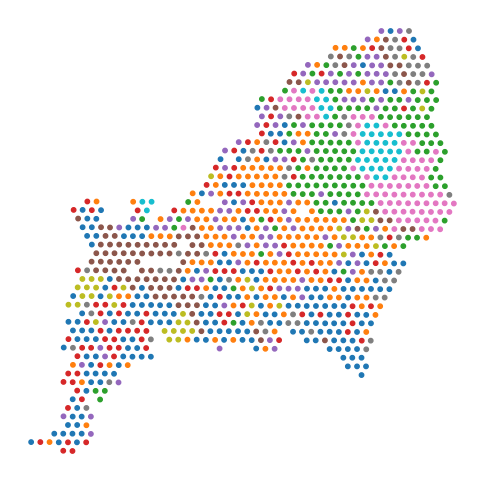

The number of genes: 36601
The number of cells: 1045


In [188]:
filePath = r"E:\00_CeSOP\data\10X_Visium_Kadur2022Human_GSM5388415_10x_Visium_data.h5ad"
annData = sc.read_h5ad(filePath)

# # 提取空间位置信息
# spatial_coords = annData.obsm['spatial']
# # 转为 DataFrame 并加入 obs
# annData.obs[['x', 'y']] = pd.DataFrame(spatial_coords, index=annData.obs.index)
# # 绘制空间分布图
# plt.scatter(annData.obs['x'], annData.obs['y'], s=2, alpha=0.5)
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.title("Spatial Distribution")
# plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# plt.show()

# 提取空间位置信息
spatial_coords = annData.obsm['spatial']
# 转为 DataFrame 并加入 obs
annData.obs[['x', 'y']] = pd.DataFrame(spatial_coords, index=annData.obs.index)
# 绘制空间分布图
df = pd.DataFrame(annData.obs[['x','y','leiden']])
# 将 'leiden' 列转为类别型并映射为数值
df['leiden'] = df['leiden'].astype('category')
df['leiden_numeric'] = df['leiden'].cat.codes  # 将类别型数据转换为数值型

plt.figure(figsize=(6, 6))
plt.scatter(df['x'], df['y'], c=df['leiden_numeric'],cmap='tab10', s=10)
# plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 添加颜色条
# plt.colorbar(scatter, label='leiden_numeric')

# 添加标题和轴标签
plt.grid(False)
plt.axis('off')
plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 显示图形
plt.show()


# 创建 DataFrame, 细胞名称为行，空间位置（x, y）为列
spatial_df = pd.DataFrame(
    spatial_coords, 
    columns=['x', 'y'],  # 空间位置列名
    index=annData.obs.index  # 细胞名称作为索引
)

# 保存为 CSV 文件
spatial_df.to_csv(r"E:\00_CeSOP\results\spatial-domain\spatial_coordinates_2022.csv")

# 转换为 Pandas DataFrame
# 稀疏矩阵形式
expression_matrix = annData.X

# 转换为普通的 NumPy 数组
dense_matrix = expression_matrix.toarray() if not isinstance(expression_matrix, np.ndarray) else expression_matrix

lung_df = pd.DataFrame(
    dense_matrix,
    index=annData.obs_names,  # 细胞名称
    columns=annData.var_names  # 基因名称
)
# print(df.head())
print("The number of genes:",len(lung_df.columns))
print("The number of cells:",len(lung_df.index))




In [70]:
t = 28
# 读取asthma gwas数据中所有基因
trait = pd.read_csv(r"E:\00_CeSOP\data\poly_posterior_prior_gene\%s_new.txt"%(t+1),sep = "\t")
trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\core\%s.txt"%(t+1),sep = "\t",header= None)[0])
trait_perigene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\periphery\%s.txt"%(t+1),sep = "\t",header= None)[0])

## 分别计算核心和外围
for gene in ["core","peri"][1:2]:
    
    # 细胞有表达的asthma核心、外围基因
    if gene == "core":
        genelist = trait_coregene
    elif gene == "peri":
        genelist = trait_perigene

    expressedGenes = lung_df.apply(lambda row: lung_df.columns[row.to_numpy().nonzero()[0]].tolist(), axis=1)
    celllist = list(lung_df.index)

    # 计算每个细胞中的结果
    count = 0
    result_list = []
    for cell in celllist:   #cell是细胞名字
        count+=1
        
        # 单细胞有表达的网络基因
        singlecell_network_genelist = list(set(expressedGenes[cell]) & set(list(G.nodes())))        
        # 构建单细胞子网络
        g = nx.subgraph(G,singlecell_network_genelist)
        core_scnet_genelist = list(set(genelist) & set(singlecell_network_genelist))
        l,lcc = Lcc(G,core_scnet_genelist)
        if (count % 10) == 0:
            print(gene,str(count)+"/"+str(len(celllist)),len(singlecell_network_genelist),len(core_scnet_genelist),lcc,str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
       
        # lcc_expresszscore
        lcczscore,lcc_expresssum_zscore,lcc_expressmean_zscore = \
            gensetLccExpressZscore(G,g,core_scnet_genelist,10,lung_df,cell)  # 随机50次
        result_list.append([cell,len(core_scnet_genelist),lcc,lcczscore,lcc_expresssum_zscore,lcc_expressmean_zscore])

    df_singcell = pd.DataFrame(result_list)
    df_singcell.columns = ["cell","genenum","lcc","lcczscore","lcc_expresssum_zscore","lcc_expressmean_zscore"]
    df_singcell.to_csv(r"E:\00_CeSOP\results\spatial-domain\%s_asthma_lung_spatial_2022.csv"%(gene))

peri 10/1045 1540 312 178 2024-11-24 20:45:36
peri 20/1045 4258 835 620 2024-11-24 20:45:49
peri 30/1045 2851 540 363 2024-11-24 20:45:55
peri 40/1045 1439 274 140 2024-11-24 20:46:01
peri 50/1045 4513 879 643 2024-11-24 20:46:06
peri 60/1045 3786 735 550 2024-11-24 20:46:12
peri 70/1045 4743 929 757 2024-11-24 20:46:18
peri 80/1045 1002 218 93 2024-11-24 20:46:25
peri 90/1045 3308 676 500 2024-11-24 20:46:29
peri 100/1045 4355 845 643 2024-11-24 20:46:35
peri 110/1045 2770 571 390 2024-11-24 20:46:41
peri 120/1045 3292 638 432 2024-11-24 20:46:46
peri 130/1045 1544 302 176 2024-11-24 20:46:51
peri 140/1045 3758 719 529 2024-11-24 20:46:56
peri 150/1045 1140 218 109 2024-11-24 20:47:03
peri 160/1045 5047 975 790 2024-11-24 20:47:08
peri 170/1045 4414 906 703 2024-11-24 20:47:13
peri 180/1045 1420 284 120 2024-11-24 20:47:19
peri 190/1045 5536 1025 785 2024-11-24 20:47:23
peri 200/1045 4395 842 658 2024-11-24 20:47:28
peri 210/1045 3828 740 536 2024-11-24 20:47:33
peri 220/1045 1979 384

In [189]:
# 读取结果文件并将对应值加入到相应的位置上
core_lcczscore_df = pd.read_csv(r"E:\00_CeSOP\results\spatial-domain\core_asthma_lung_spatial_2022.csv")[["cell","lcczscore"]]
core_lcczscore_df.columns = ["cell","lcczscore-core"]
peri_lcczscore_df = pd.read_csv(r"E:\00_CeSOP\results\spatial-domain\peri_asthma_lung_spatial_2022.csv")[["cell","lcczscore"]]
peri_lcczscore_df.columns = ["cell","lcczscore-peri"]

cell_loc = pd.read_csv(r"E:\00_CeSOP\results\spatial-domain\spatial_coordinates_2022.csv")
cell_loc.columns = ["cell","x","y"]

In [190]:
# 将所有 DataFrame 设置为以 'cell' 为索引
cell_loc = cell_loc.set_index('cell')
core_lcczscore_df = core_lcczscore_df.set_index('cell')
peri_lcczscore_df = peri_lcczscore_df.set_index('cell')

# 使用 concat 按列拼接
merged_df = pd.concat([cell_loc, core_lcczscore_df,peri_lcczscore_df], axis=1)

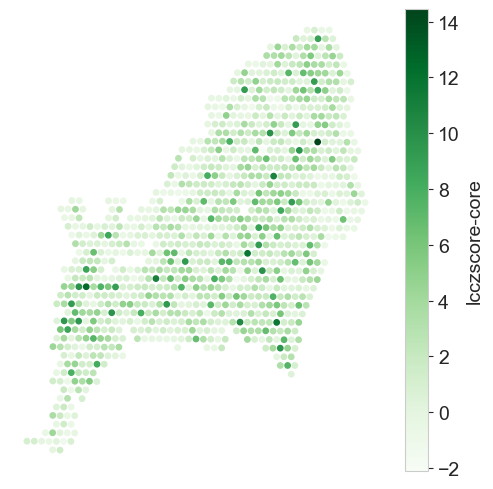

In [192]:
# 创建散点图，使用 gene_1 列的值决定颜色，值越大颜色越深
# epsilon = 1e-10
# merged_df['lcczscore-core'] = -np.log10(merged_df['lcczscore-core'] + epsilon)
plt.figure(figsize=(6, 6))

# 使用 'gene_1' 列的值来决定颜色，cmap 设置为 'plasma'（或其他颜色映射）
scatter = plt.scatter(
    merged_df['x'], 
    merged_df['y'], 
    c=merged_df['lcczscore-core'],  # 使用 'gene_1' 列的值作为颜色的依据
    cmap='Greens',           # 'plasma' 是一个渐变色，从暗到亮的映射
    s=15,                   # 设置点的大小
    # norm=plt.Normalize(vmin=-5, vmax=15) 
    alpha=1                # 设置透明度
)

# 添加颜色条
plt.colorbar(scatter, label='lcczscore-core')

# 添加标题和轴标签
plt.grid(False)
plt.axis('off')
plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 显示图形
plt.show()

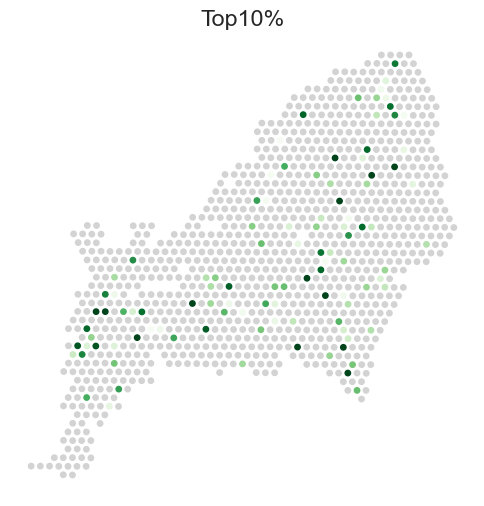

In [194]:
threshold = merged_df['lcczscore-core'].quantile(0.9)  # top 10%
# 创建颜色数组，默认设置为灰色
colors = ['#D3D3D3' if val < threshold else plt.cm.Greens((val - threshold) / threshold) for val in merged_df['lcczscore-core']]
plt.figure(figsize=(6, 6))

# 使用 'gene_1' 列的值来决定颜色，cmap 设置为 'plasma'（或其他颜色映射）
scatter = plt.scatter(
    merged_df['x'], 
    merged_df['y'], 
    c=colors,  # 使用 'gene_1' 列的值作为颜色的依据
    # cmap='Greens',           # 'plasma' 是一个渐变色，从暗到亮的映射
    s=15,                   # 设置点的大小
    # norm=plt.Normalize(vmin=-5, vmax=15) 
    alpha=1                # 设置透明度
)

# 添加颜色条
# plt.colorbar(scatter, label='lcczscore-core')

# 添加标题和轴标签
plt.grid(False)
plt.axis('off')
plt.title("Top10%")
plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 显示图形
plt.show()

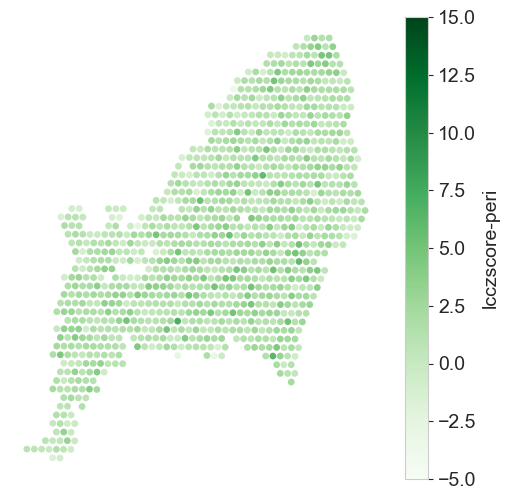

In [124]:
plt.figure(figsize=(6, 6))

# 使用 'gene_1' 列的值来决定颜色，cmap 设置为 'plasma'（或其他颜色映射）
scatter = plt.scatter(
    merged_df['x'], 
    merged_df['y'], 
    c=merged_df['lcczscore-peri'],  # 使用 'gene_1' 列的值作为颜色的依据
    cmap='Greens',           # 'plasma' 是一个渐变色，从暗到亮的映射
    s=15,                   # 设置点的大小
    norm=plt.Normalize(vmin=-5, vmax=15) 
    # alpha=0.8                # 设置透明度
)

# 添加颜色条
plt.colorbar(scatter, label='lcczscore-peri')

# 添加标题和轴标签
plt.grid(False)
plt.axis('off')
plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 显示图形
plt.show()

AAACAGAGCGACTCCT-1     3
AAACAGGGTCTATATT-1     4
AAACCGGGTAGGTACC-1     0
AAACCGTTCGTCCAGG-1     5
AAACTTGCAAACGTAT-1     4
                      ..
TTGTTAGCAAATTCGA-1     1
TTGTTCAGTGTGCTAC-1     3
TTGTTTCACATCCAGG-1     4
TTGTTTCATTAGTCTA-1    10
TTGTTTCCATACAACT-1     0
Name: leiden, Length: 1175, dtype: category
Categories (12, object): ['0', '1', '2', '3', ..., '8', '9', '10', '11']

In [172]:
filePath = r"E:\00_CeSOP\data\10X_Visium_Kadur2022Human_GSM5388414_10x_Visium_data.h5ad"
annData = sc.read_h5ad(filePath)

# 提取空间位置信息
spatial_coords = annData.obsm['spatial']
# 转为 DataFrame 并加入 obs
annData.obs[['x', 'y']] = pd.DataFrame(spatial_coords, index=annData.obs.index)
# 绘制空间分布图
# plt.scatter(annData.obs['x'], annData.obs['y'], s=2, alpha=0.5)
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.title("Spatial Distribution")
# plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# plt.show()
# 
# 
# # 创建 DataFrame, 细胞名称为行，空间位置（x, y）为列
# spatial_df = pd.DataFrame(
#     spatial_coords, 
#     columns=['x', 'y'],  # 空间位置列名
#     index=annData.obs.index  # 细胞名称作为索引
# )
# 
# # 保存为 CSV 文件
# spatial_df.to_csv(r"E:\00_CeSOP\results\spatial-domain\spatial_coordinates_2022_GSM5388414.csv")

# 转换为 Pandas DataFrame
# 稀疏矩阵形式
expression_matrix = annData.X

# 转换为普通的 NumPy 数组
dense_matrix = expression_matrix.toarray() if not isinstance(expression_matrix, np.ndarray) else expression_matrix

lung_df = pd.DataFrame(
    dense_matrix,
    index=annData.obs_names,  # 细胞名称
    columns=annData.var_names  # 基因名称
)
# print(df.head())
print("The number of genes:",len(lung_df.columns))
print("The number of cells:",len(lung_df.index))

The number of genes: 36601
The number of cells: 1175


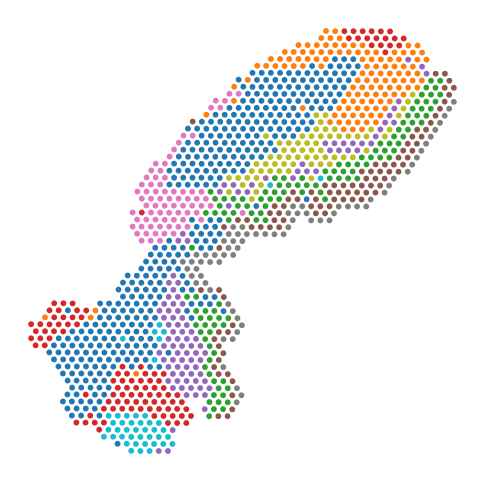

In [184]:

# 提取空间位置信息
spatial_coords = annData.obsm['spatial']
# 转为 DataFrame 并加入 obs
annData.obs[['x', 'y']] = pd.DataFrame(spatial_coords, index=annData.obs.index)
# 绘制空间分布图
df = pd.DataFrame(annData.obs[['x','y','leiden']])
# 将 'leiden' 列转为类别型并映射为数值
df['leiden'] = df['leiden'].astype('category')
df['leiden_numeric'] = df['leiden'].cat.codes  # 将类别型数据转换为数值型

plt.figure(figsize=(6, 6))
plt.scatter(df['x'], df['y'], c=df['leiden_numeric'],cmap='tab10', s=10)
# plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 添加颜色条
plt.colorbar(scatter, label='leiden_numeric')

# 添加标题和轴标签
plt.grid(False)
plt.axis('off')
plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 显示图形
plt.show()


In [128]:
t = 28
# 读取asthma gwas数据中所有基因
trait = pd.read_csv(r"E:\00_CeSOP\data\poly_posterior_prior_gene\%s_new.txt"%(t+1),sep = "\t")
trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\core\%s.txt"%(t+1),sep = "\t",header= None)[0])
trait_perigene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\periphery\%s.txt"%(t+1),sep = "\t",header= None)[0])

## 分别计算核心和外围
for gene in ["core","peri"][1:2]:
    
    # 细胞有表达的asthma核心、外围基因
    if gene == "core":
        genelist = trait_coregene
    elif gene == "peri":
        genelist = trait_perigene

    expressedGenes = lung_df.apply(lambda row: lung_df.columns[row.to_numpy().nonzero()[0]].tolist(), axis=1)
    celllist = list(lung_df.index)

    # 计算每个细胞中的结果
    count = 0
    result_list = []
    for cell in celllist:   #cell是细胞名字
        count+=1
        
        # 单细胞有表达的网络基因
        singlecell_network_genelist = list(set(expressedGenes[cell]) & set(list(G.nodes())))        
        # 构建单细胞子网络
        g = nx.subgraph(G,singlecell_network_genelist)
        core_scnet_genelist = list(set(genelist) & set(singlecell_network_genelist))
        l,lcc = Lcc(G,core_scnet_genelist)
        if (count % 10) == 0:
            print(gene,str(count)+"/"+str(len(celllist)),len(singlecell_network_genelist),len(core_scnet_genelist),lcc,str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
       
        # lcc_expresszscore
        lcczscore,lcc_expresssum_zscore,lcc_expressmean_zscore = \
            gensetLccExpressZscore(G,g,core_scnet_genelist,10,lung_df,cell)  # 随机50次
        result_list.append([cell,len(core_scnet_genelist),lcc,lcczscore,lcc_expresssum_zscore,lcc_expressmean_zscore])

    df_singcell = pd.DataFrame(result_list)
    df_singcell.columns = ["cell","genenum","lcc","lcczscore","lcc_expresssum_zscore","lcc_expressmean_zscore"]
    df_singcell.to_csv(r"E:\00_CeSOP\results\spatial-domain\%s_asthma_lung_spatial_2022_GSM5388414.csv"%(gene))

peri 10/1175 6602 1202 997 2024-11-24 21:49:09
peri 20/1175 1017 219 85 2024-11-24 21:49:16
peri 30/1175 1460 303 151 2024-11-24 21:49:19
peri 40/1175 1789 359 196 2024-11-24 21:49:23
peri 50/1175 637 132 57 2024-11-24 21:49:27
peri 60/1175 1638 324 188 2024-11-24 21:49:30
peri 70/1175 5370 960 707 2024-11-24 21:49:36
peri 80/1175 1408 291 146 2024-11-24 21:49:39
peri 90/1175 1276 264 116 2024-11-24 21:49:44
peri 100/1175 2526 494 333 2024-11-24 21:49:48
peri 110/1175 1663 327 162 2024-11-24 21:49:53
peri 120/1175 1185 249 88 2024-11-24 21:49:57
peri 130/1175 2039 380 199 2024-11-24 21:50:02
peri 140/1175 6870 1259 1020 2024-11-24 21:50:08
peri 150/1175 688 125 41 2024-11-24 21:50:12
peri 160/1175 679 131 16 2024-11-24 21:50:15
peri 170/1175 2319 431 274 2024-11-24 21:50:20
peri 180/1175 797 147 21 2024-11-24 21:50:27
peri 190/1175 2532 478 280 2024-11-24 21:50:31
peri 200/1175 2336 432 244 2024-11-24 21:50:37
peri 210/1175 2626 506 337 2024-11-24 21:50:42
peri 220/1175 1221 249 128 20

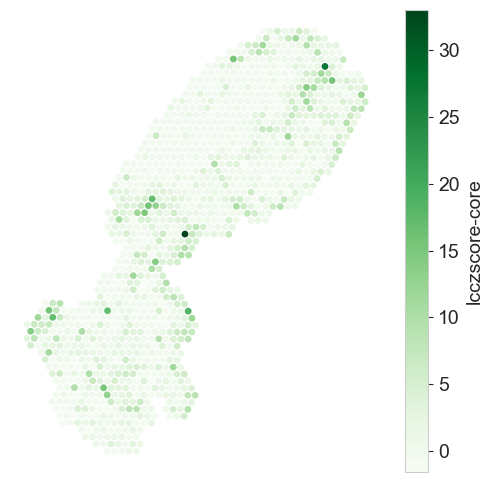

In [185]:
# 读取结果文件并将对应值加入到相应的位置上
core_lcczscore_df = pd.read_csv(r"E:\00_CeSOP\results\spatial-domain\core_asthma_lung_spatial_2022_GSM5388414.csv")[["cell","lcczscore"]]
core_lcczscore_df.columns = ["cell","lcczscore-core"]
peri_lcczscore_df = pd.read_csv(r"E:\00_CeSOP\results\spatial-domain\peri_asthma_lung_spatial_2022_GSM5388414.csv")[["cell","lcczscore"]]
peri_lcczscore_df.columns = ["cell","lcczscore-peri"]

cell_loc = pd.read_csv(r"E:\00_CeSOP\results\spatial-domain\spatial_coordinates_2022_GSM5388414.csv")
cell_loc.columns = ["cell","x","y"]

# 将所有 DataFrame 设置为以 'cell' 为索引
cell_loc = cell_loc.set_index('cell')
core_lcczscore_df = core_lcczscore_df.set_index('cell')
peri_lcczscore_df = peri_lcczscore_df.set_index('cell')

# 使用 concat 按列拼接
merged_df = pd.concat([cell_loc, core_lcczscore_df,peri_lcczscore_df], axis=1)

plt.figure(figsize=(6, 6))

# 使用 'gene_1' 列的值来决定颜色，cmap 设置为 'plasma'（或其他颜色映射）
scatter = plt.scatter(
    merged_df['x'], 
    merged_df['y'], 
    c=merged_df['lcczscore-core'],  # 使用 'gene_1' 列的值作为颜色的依据
    cmap='Greens',           # 'plasma' 是一个渐变色，从暗到亮的映射
    s=15,                   # 设置点的大小
    # norm=plt.Normalize(vmin=-5, vmax=15) 
    alpha=1                # 设置透明度
)

# 添加颜色条
plt.colorbar(scatter, label='lcczscore-core')

# 添加标题和轴标签
plt.grid(False)
plt.axis('off')
plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 显示图形
plt.show()

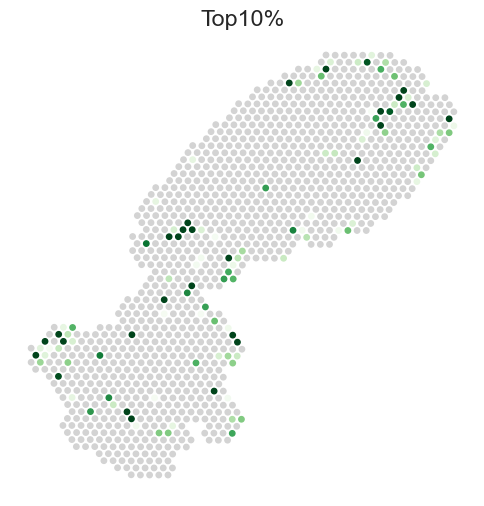

In [187]:
threshold = merged_df['lcczscore-core'].quantile(0.9)  # top 10%
# 创建颜色数组，默认设置为灰色
colors = ['#D3D3D3' if val < threshold else plt.cm.Greens((val - threshold) / threshold) for val in merged_df['lcczscore-core']]
plt.figure(figsize=(6, 6))

# 使用 'gene_1' 列的值来决定颜色，cmap 设置为 'plasma'（或其他颜色映射）
scatter = plt.scatter(
    merged_df['x'], 
    merged_df['y'], 
    c=colors,  # 使用 'gene_1' 列的值作为颜色的依据
    # cmap='Greens',           # 'plasma' 是一个渐变色，从暗到亮的映射
    s=15,                   # 设置点的大小
    # norm=plt.Normalize(vmin=-5, vmax=15) 
    alpha=1                # 设置透明度
)

# 添加颜色条
# plt.colorbar(scatter, label='lcczscore-core')

# 添加标题和轴标签
plt.grid(False)
plt.axis('off')
plt.title("Top10%")
plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 显示图形
plt.show()

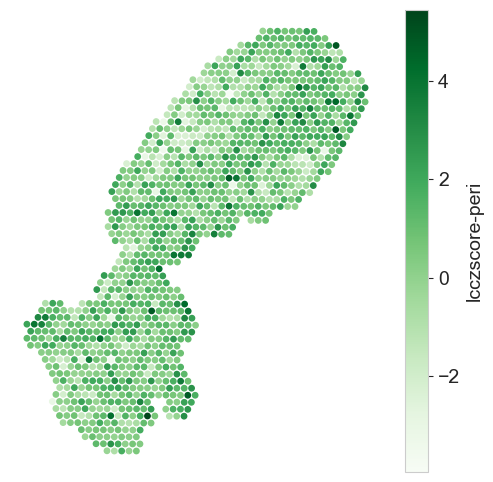

In [130]:
plt.figure(figsize=(6, 6))

# 使用 'gene_1' 列的值来决定颜色，cmap 设置为 'plasma'（或其他颜色映射）
scatter = plt.scatter(
    merged_df['x'], 
    merged_df['y'], 
    c=merged_df['lcczscore-peri'],  # 使用 'gene_1' 列的值作为颜色的依据
    cmap='Greens',           # 'plasma' 是一个渐变色，从暗到亮的映射
    s=15,                   # 设置点的大小
    # norm=plt.Normalize(vmin=-5, vmax=15) 
    alpha=1                # 设置透明度
)

# 添加颜色条
plt.colorbar(scatter, label='lcczscore-peri')

# 添加标题和轴标签
plt.grid(False)
plt.axis('off')
plt.gca().invert_yaxis()  # Visium 数据通常需要 Y 轴翻转
# 显示图形
plt.show()

In [195]:
## 单细胞

data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\29\top10_core_lcczscore.csv")
data_lung = data[data["tissue"]=="Lung"]
data_lung.sort_values("fisher's pvalue")

,Unnamed: 0,tissue,celltype,cellnum,relatedCellnum,jaccard,fisher's pvalue,hypergeom pvalue
187,187,Lung,type ii pneumocyte,9146,2572,0.281216,4.162246e-221,0.000000e+00
172,172,Lung,macrophage,12160,1913,0.157319,4.059230e-41,1.976050e-88
153,153,Lung,basal cell,2188,329,0.150366,2.297532e-07,8.941909e-14
182,182,Lung,respiratory goblet cell,754,139,0.184350,1.451303e-06,1.586437e-12
150,150,Lung,adventitial cell,373,68,0.182306,7.476825e-04,9.533787e-07
186,186,Lung,type i pneumocyte,211,44,0.208531,1.399196e-03,2.130485e-06
170,170,Lung,lung ciliated cell,602,87,0.144518,1.092406e-02,3.415484e-04
183,183,Lung,respiratory mucous cell,8,3,0.375000,1.000000e-01,3.809004e-02
184,184,Lung,serous cell of epithelium of bronchus,15,3,0.200000,2.988506e-01,1.840571e-01
173,173,Lung,mesothelial cell,17,3,0.176471,3.005865e-01,2.381989e-01
